# 게임 데이터 분석 프로젝트

야구의 세이버 매트릭스처럼 농구, 축구 등 기성 스포츠에서 데이터 분석이 활발하게 진행되고 있지만,  
오히려 데이터 쌓기가 가장 쉬울 수 있는 e스포츠에서는 아직 가공하지 않은 지표뿐 확립된 모델이 없습니다.  
아무래도 모델이 나오기에는 기성 스포츠에 비해 역사가 짧기 때문이고, 특히 게임들은 게임이 고이거나 지루해지는 것을 방지하기 위해 잦은 대규모 패치를 진행합니다. 따라서 규칙이 분기별로 바뀌지 않는 기성 스포츠와 달리 방대한 분량의 데이터를 쌓기 힘듭니다.  

오늘은 온라인 배틀 아레나 게임인 '리그 오브 레전드' 데이터를 사용해 기본적인 게임 데이터 분석을 해보고자 합니다.  
분석을 통해 알아볼 인사이트는 다음과 같습니다.
1. 게임을 승리하는데 있어 어떤 특성(라인)이 현재 제일 영향력이 큰지, 지금은 어떤 '메타'인가?
2. 게임을 승리하는데 게임 시간이 어떤 영향을 끼치는지

### Data Description

- dataset : league of legends pre-season11, season 11 solo rank (high elo) game
- source : op.gg (python scrapy crawling)  
---
  
    - result : target, 게임의 승패 여부(블루 진영 기준)
    - server : 게임 서버로 www(한국), euw(서유럽), na(미국), eune(동유럽)
    - team_1 : Blue team의 탑, 정글, 미드, 원딜, 서폿 순
    - team_2 : Red team의 탑, 정글, 미드, 원딜, 서폿 순
    - timestamp : 게임 시작 일시
    - game_length : 게임이 끝나기까지 걸린 시간

In [7]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [220]:
import warnings

warnings.filterwarnings(action='ignore')

In [2]:
df = pd.read_csv('s11_2021.csv')
df.head()

,result,server,timestamp,game_length,blue_top,blue_jug,blue_mid,blue_adc,blue_sup,red_top,red_jug,red_mid,red_adc,red_sup
0,Defeat,www,2021-02-16 04:19:20,1111,Malphite,Kha'Zix,Orianna,Jinx,Rell,Jayce,Taliyah,Syndra,Samira,Alistar
1,Defeat,www,2021-02-16 03:18:28,1111,Gnar,Sejuani,Yasuo,Tristana,Alistar,Irelia,Elise,Azir,Kai'Sa,Rell
2,Victory,www,2021-02-16 02:30:37,1111,Gragas,Graves,Syndra,Senna,Trundle,Sion,Hecarim,Twisted Fate,Xayah,Rell
3,Victory,www,2021-02-16 16:09:47,1249,Shen,Hecarim,Orianna,Kalista,Jarvan IV,Gragas,Udyr,Zoe,Tristana,Seraphine
4,Defeat,www,2021-02-16 01:42:04,1111,Renekton,Nidalee,Orianna,Miss Fortune,Seraphine,Camille,Hecarim,Rumble,Samira,Gragas


In [3]:
#위의 데이터는 10월 25일부터 2월 16일까지의 데이터입니다. 
#새로 크롤링을 해서 가장 최근까지의 데이터를 추가하도록 하겠습니다.
df['timestamp'].sort_values()

5097    2020-10-25 02:07:41
5078    2020-10-25 02:47:18
5063    2020-10-25 03:23:33
5049    2020-10-25 04:10:32
5357    2020-10-26 19:30:26
               ...         
55      2021-02-16 17:16:13
2163    2021-02-16 17:31:07
25      2021-02-16 17:31:57
508     2021-02-16 17:38:33
2647    2021-02-16 17:41:12
Name: timestamp, Length: 6861, dtype: object

### 데이터 전처리

In [54]:
new = pd.read_json('db.json')
print(new.shape)
new.head()

(8334, 6)


,result,server,team_1,team_2,timestamp,game_length
0,Defeat,www,"[Malphite, Kha'Zix, Orianna, Jinx, Rell]","[Jayce, Taliyah, Syndra, Samira, Alistar]",2021-02-16 04:19:20,18m 31s
1,Defeat,www,"[Gnar, Sejuani, Yasuo, Tristana, Alistar]","[Irelia, Elise, Azir, Kai'Sa, Rell]",2021-02-16 03:18:28,18m 31s
2,Victory,www,"[Gragas, Graves, Syndra, Senna, Trundle]","[Sion, Hecarim, Twisted Fate, Xayah, Rell]",2021-02-16 02:30:37,18m 31s
3,Victory,www,"[Shen, Hecarim, Orianna, Kalista, Jarvan IV]","[Gragas, Udyr, Zoe, Tristana, Seraphine]",2021-02-16 16:09:47,20m 49s
4,Defeat,www,"[Renekton, Nidalee, Orianna, Miss Fortune, Ser...","[Camille, Hecarim, Rumble, Samira, Gragas]",2021-02-16 01:42:04,18m 31s


In [55]:
# Select only interests
temp_df = new[['game_length', 'result', 'team_1', 'team_2']] 
blue = temp_df['team_1']
red = temp_df['team_2']
n = len(new)

blue_champs = []
red_champs = []

#split by comma
for i in range(0,n):
    blue_champs += [','.join(blue[i]).split(',')]
    red_champs += [','.join(red[i]).split(',')]

top = []
jg = []
mid = []
adc = []
sup = []
for i in range(0, n):
    top += [blue_champs[i][0]]
    jg += [blue_champs[i][1]]
    mid += [blue_champs[i][2]]
    adc += [blue_champs[i][3]]
    sup += [blue_champs[i][4]]

top_2 = []
jg_2 = []
mid_2 = []
adc_2 = []
sup_2 = []
for i in range(0, n):
    top_2 += [red_champs[i][0]]
    jg_2 += [red_champs[i][1]]
    mid_2 += [red_champs[i][2]]
    adc_2 += [red_champs[i][3]]
    sup_2 += [red_champs[i][4]]

# blue team
new['blue_top'] = top
new['blue_jug'] = jg
new['blue_mid'] = mid
new['blue_adc'] = adc
new['blue_sup'] = sup

#red team
new['red_top'] = top_2
new['red_jug'] = jg_2
new['red_mid'] = mid_2
new['red_adc'] = adc_2
new['red_sup'] = sup_2

In [56]:
#필요 없는 칼럼 드랍
new = new.drop(['team_1', 'team_2'], axis=1)

In [57]:
#game_length convert string to int
import re
len_sum_lst = []

for i in new['game_length']:
    minute = i[:re.search('m', i).start()]
    second = i[re.search('m', i).start() + 2:re.search('s', i).end()-1]
    len_sum = 60 * int(minute) + int(second)
    len_sum_lst.append(len_sum)

new['game_length'] = len_sum_lst

In [58]:
new.head()

,result,server,timestamp,game_length,blue_top,blue_jug,blue_mid,blue_adc,blue_sup,red_top,red_jug,red_mid,red_adc,red_sup
0,Defeat,www,2021-02-16 04:19:20,1111,Malphite,Kha'Zix,Orianna,Jinx,Rell,Jayce,Taliyah,Syndra,Samira,Alistar
1,Defeat,www,2021-02-16 03:18:28,1111,Gnar,Sejuani,Yasuo,Tristana,Alistar,Irelia,Elise,Azir,Kai'Sa,Rell
2,Victory,www,2021-02-16 02:30:37,1111,Gragas,Graves,Syndra,Senna,Trundle,Sion,Hecarim,Twisted Fate,Xayah,Rell
3,Victory,www,2021-02-16 16:09:47,1249,Shen,Hecarim,Orianna,Kalista,Jarvan IV,Gragas,Udyr,Zoe,Tristana,Seraphine
4,Defeat,www,2021-02-16 01:42:04,1111,Renekton,Nidalee,Orianna,Miss Fortune,Seraphine,Camille,Hecarim,Rumble,Samira,Gragas


In [62]:
#기존 데이터의 df와 new를 합치겠습니다
df = pd.concat([df, new]).reset_index(drop=True)

In [67]:
#중복된 셀 삭제
df = df.drop_duplicates()

In [73]:
#10월 25일부터 2월 25일까지의 데이터입니다. 
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp'].sort_values()

/Users/lana/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


5097    2020-10-25 02:07:41
5078    2020-10-25 02:47:18
5063    2020-10-25 03:23:33
5049    2020-10-25 04:10:32
5357    2020-10-26 19:30:26
                ...        
12510   2021-02-25 13:12:16
13400   2021-02-25 13:15:37
14222   2021-02-25 13:15:42
12613   2021-02-25 13:32:05
12116   2021-02-25 13:32:05
Name: timestamp, Length: 14933, dtype: datetime64[ns]

### EDA

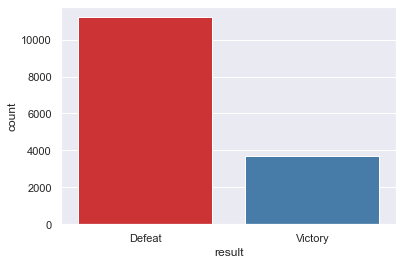

In [106]:
#target class의 분포
sns.set(style="darkgrid")
ax = sns.countplot(x="result", data=df, palette="Set1")

In [81]:
#블루 진영 승리 25%, 패배 75%로 구성되어 있는 다소 imbalanced한 클래스입니다.
df['result'].value_counts(normalize=True)

Defeat     0.750887
Victory    0.249113
Name: result, dtype: float64

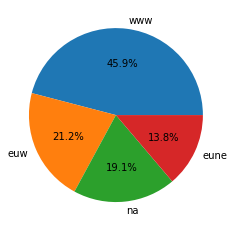

In [82]:
#한국 서버의 데이터가 46%로 가장 많습니다
ratio = df['server'].value_counts()
labels = ['www', 'euw','na','eune']

plt.pie(ratio, labels=labels, autopct='%.1f%%')
plt.show()

In [80]:
df.describe(include='object')

,result,server,blue_top,blue_jug,blue_mid,blue_adc,blue_sup,red_top,red_jug,red_mid,red_adc,red_sup
count,14933,14933,14933,14933,14933,14933,14933,14933,14933,14933,14933,14933
unique,2,4,116,72,125,98,70,116,74,121,107,77
top,Defeat,www,Gnar,Graves,Orianna,Kai'Sa,Thresh,Gnar,Nidalee,Twisted Fate,Kai'Sa,Thresh
freq,11213,6859,1588,1745,947,3080,1838,1360,1635,860,2903,1734


1. 진영별 가장 높은 픽률을 보이는 챔프
    - 블루 진영) 탑 나르, 정글 그레이브즈, 미드 오리아나, 원딜 카이사, 서포터 쓰레쉬
    - 레드 진영) 탑 나르, 정글 니달리, 미드 트위스트 페이트, 원딜 카이사, 서포트 쓰레쉬
    - 정글과 미드만 다르다
2. 그 중 카이사는 (블루기준) 20%, 쓰레쉬는 12% 정도로 자주 나오는 편이다. 카이사는 다섯판 하면 한 판은 꼭 나오는 것.
    - 다만 카이사 - 쓰레쉬 봇 듀오는 1%로 각각 다른 챔피언이랑 자주 나온다. 카이사 경기 중 10%는 렐이랑 함께 나온다.
    - 카이사 블루 승률은 25%, 카이사 레드 승률은 24.8%로 괜찮은 편이다. 
3. 총 153개의 챔피언 중 가장 다양한 챔피언이 나오는 라인은 미드이며(125, 121) 서포터와 정글이 가장 정해진 챔피언이 나오는 편이다. (70대)


In [94]:
#카이사가 블루 진영의 원딜일 때 데이터
df[(df['blue_adc'] == 'Kai\'Sa')].describe(include='object')

,result,server,blue_top,blue_jug,blue_mid,blue_adc,blue_sup,red_top,red_jug,red_mid,red_adc,red_sup
count,3080,3080,3080,3080,3080,3080,3080,3080,3080,3080,3080,3080
unique,2,4,81,52,94,1,45,84,55,92,50,50
top,Defeat,www,Gnar,Graves,Orianna,Kai'Sa,Rell,Gnar,Nidalee,Twisted Fate,Samira,Thresh
freq,2288,1685,395,343,191,3080,440,317,425,180,392,472


In [99]:
df[(df['red_adc'] == 'Kai\'Sa')]['result'].value_counts()

Defeat     2182
Victory     721
Name: result, dtype: int64

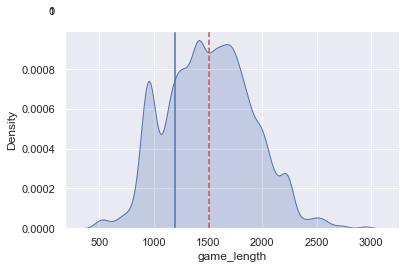

In [105]:
#게임 시간 분석
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0, 1)})
mean=df['game_length'].mean()
sns.kdeplot(data=df['game_length'], shade=True, ax=ax_hist);
ax_hist.axvline(mean, color='r', linestyle='--');
ax_hist.axvline(20*60, color='b');

In [104]:
df.describe()

,game_length
count,14933.000000
mean,1508.337909
std,395.496921
min,495.000000
25%,1224.000000
50%,1507.000000
75%,1779.000000
max,2946.000000


1. 평균 게임 시간은 1508초로 25분 가량이며, 전체 게임의 25%가 20분 전에 끝난다.
2. 대체로 정규 분포를 따르고 있으며, 1000초(16분) 이전에 끝나는 게임은 항복(서렌더)으로 게임이 빠르게 끝나는 경우이다.
3. 빠르게 게임이 끝나는 경우 특이점은 북미 서버 경기의 비중이 좀 더 커졌다는 것이다. 

In [112]:
df[df['game_length'] < 1000]['server'].value_counts(normalize=True)

www     0.497782
na      0.264170
euw     0.123213
eune    0.114835
Name: server, dtype: float64

In [113]:
df['server'].value_counts(normalize=True)

www     0.459318
euw     0.211612
na      0.191187
eune    0.137883
Name: server, dtype: float64

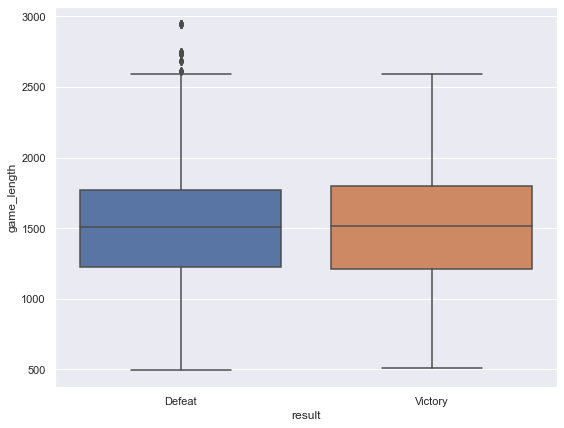

In [114]:
#블루 진영 기준 승리하거나 패배할때 게임 시간은 큰 차이가 없다.
#블루 진영 기준 패배할 때 게임 시간이 긴 아웃라이어들이 발생한다.
plt.figure(figsize=(9,7))
sns.boxplot(x="result", 
            y="game_length",
            data=df)
plt.show()

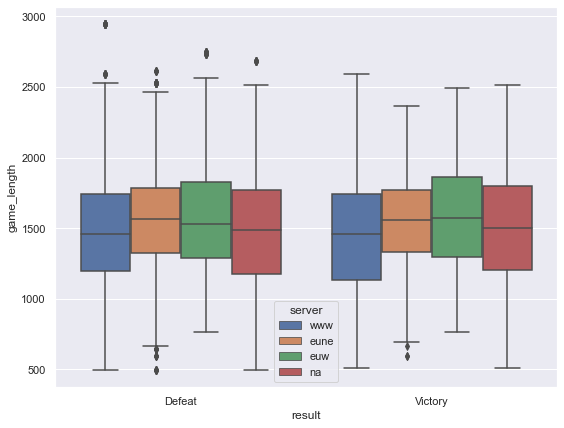

In [115]:
#서버 기준으로 승리/패배 게임 시간 비교
plt.figure(figsize=(9,7))
sns.boxplot(x="result", 
            y="game_length",
            hue='server',
            data=df)
plt.show()

- 전반적으로 서버와 상관없이 승리/패배간의 게임 시간 차이는 크지 않다. 
- 다만 서버별로 비교하자면, 승리/패배와 상관없이 한국의 게임 시간이 가장 넓게 분포되어 있으며 동유럽이 제일 몰려 있는 것을 알 수 있다. 
- 평균 게임 시간은 동유럽, 서유럽, 북미, 한국 순으로 길다. 
- 동유럽의 게임들 중 경기 시간이 극단적으로 짧은 outlier들이 발생하였다 (비정상적인 게임 종료)

In [137]:
#minimum은 boxplot에서 아웃라이어를 제외한 최소 값
#패배 88%의 높은 지분을 차지하고 있기 때문에, 해당 데이터는 모델 형성에 악영향을 줄 수 있으므로 삭제
df[(df['server'] == 'eune') & (df['game_length'] < minimum)]['result'].value_counts(normalize=True)

Defeat     0.888889
Victory    0.111111
Name: result, dtype: float64

In [132]:
df[df['server'] == 'eune'].describe()

,game_length
count,2059.000000
mean,1547.640117
std,382.326442
min,495.000000
25%,1327.000000
50%,1561.000000
75%,1782.000000
max,2611.000000


In [136]:
minimum = 1327 - (1782-1327)*1.5
minimum

644.5

In [141]:
eune_outlier = df[(df['server'] == 'eune') & (df['game_length'] < minimum)].index

In [144]:
#eune_outlier 삭제
df = df.drop(eune_outlier).reset_index()

In [175]:
df = df.drop('index', axis=1)

In [178]:
df = df.drop_duplicates()

In [180]:
temp = df.copy()

In [181]:
#가장 많이 나온 조합
temp['blue_comp'] = df['blue_top'] + df['blue_jug'] + df['blue_mid'] + df['blue_adc'] + df['blue_sup']
temp['red_comp'] = df['red_top'] + df['red_jug'] + df['red_mid'] + df['red_adc'] + df['red_sup']

In [182]:
temp.describe(include='object')

,result,server,blue_top,blue_jug,blue_mid,blue_adc,blue_sup,red_top,red_jug,red_mid,red_adc,red_sup,blue_comp,red_comp
count,10910,10910,10910,10910,10910,10910,10910,10910,10910,10910,10910,10910,10910,10910
unique,2,4,116,72,125,98,70,116,74,121,106,77,6269,6267
top,Defeat,www,Gnar,Graves,Orianna,Kai'Sa,Thresh,Gnar,Graves,Orianna,Kai'Sa,Thresh,CamilleGravesGalioEzrealLeona,GnarNidaleePantheonSamiraAlistar
freq,8194,5110,1120,1344,700,2181,1348,947,1223,619,2076,1248,14,14


1. 블루 진영 가장 많이 나온 조합은 [카밀, 그레이브즈, 갈리오, 이즈리얼, 레오나]
2. 레드 진영 가장 많이 나온 조합은 [나르, 니달리, 판테온, 사미라, 알리스타]이다
3. 그렇지만 총 10910판 중 14판 뿐이라 굉장히 적다. -> 게임을 승리하는데에 있어 좋은 챔피언은 있을지라도 정해진 조합은 없다.
4. 또 10910개 중 6269개의 조합이 있기 때문에 랭크 게임에서는 굉장히 다양한 조합이 사용되는 것을 알 수 있다. 

### 모델 만들기

- 사용할 모델 : RandomForestClassifier, XGBClassifier
- 특정 조합을 기반으로 게임의 승/패를 예측해 볼 것이기 때문에 분류 모델을 선택했습니다.
- 가설 : 게임의 승리에 가장 많은 영향을 끼치는 특성(라인)은 미드, 가장 적은 영향을 끼치는 특성은 서폿일것이다. 
- 긍정, 부정을 떠나서 가장 많은 영향을 끼치는 라인이 이번 시즌의 '메타'일 것이다. 

In [204]:
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [194]:
#mapping target 'result' to 0,1
df['result'] = df['result'].map({'Defeat': 0, 'Victory': 1})

In [187]:
#모델에 쓰지 않을 timestamp 칼럼 삭제
df = df.drop('timestamp', axis=1)

target = 'result'
features = df.drop(columns=[target]).columns

In [196]:
# 데이터를 트레인/검증 세트로 분리합니다 
train, val = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df[target], random_state=2)

train.shape, val.shape

((8728, 13), (2182, 13))

In [197]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [222]:
#Target encoding
#class_weight=balance 옵션
#max_leaf_nodes 옵션을 줘서 accuracy를 낮추고 recall 높임
pipe_tar = make_pipeline(
    TargetEncoder(), 
    RandomForestClassifier(random_state=42, 
                           n_estimators=2000,
                           max_leaf_nodes=5,
                           #min_samples_leaf=1,
                           n_jobs=-1,
                          class_weight='balanced')
)
pipe_tar.fit(X_train, y_train)
print('검증 정확도', pipe_tar.score(X_val, y_val))
print('f1_score : ', f1_score(y_val,pipe_tar.predict(X_val)))

검증 정확도 0.5004582951420715
f1_score :  0.3204488778054863


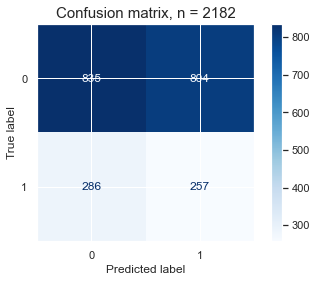

In [217]:
#f1_score가 굉장히 낮은 것을 볼 수 있다.
#False Negative가 많은 것을 확인할 수 있다
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe_tar, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

In [218]:
#'Victory' label의 recall이 0.11로 낮아서 max_leaf_nodes 옵션을 주고 늘림
# 그 만큼 0의 recall이 떨어짐
from sklearn.metrics import classification_report
print(classification_report(y_val, pipe_tar.predict(X_val)))

              precision    recall  f1-score   support

           0       0.74      0.51      0.61      1639
           1       0.24      0.47      0.32       543

    accuracy                           0.50      2182
   macro avg       0.49      0.49      0.46      2182
weighted avg       0.62      0.50      0.53      2182



In [226]:
#scale_pos_weight is the ratio of number of 
#negative class to the positive class.
ratio = df['result'].value_counts()[0] / df['result'].value_counts()[1]
ratio

3.0169366715758468

In [ ]:
import warnings
warnings.filterwarnings(action='ignore', category=Warning, module='xgboost')

In [255]:
from xgboost import XGBClassifier

pipe = make_pipeline(
    TargetEncoder(),
    XGBClassifier(n_estimators=2000
                  , random_state=42
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2
                  , scale_pos_weight= ratio
                 )
)

pipe.fit(X_train, y_train);
y_pred = pipe.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))
print('f1_score : ', f1_score(y_val, y_pred))
print(classification_report(y_pred, y_val))

[17:08:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
검증 정확도:  0.6727772685609532
f1_score :  0.2468354430379747
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1777
           1       0.22      0.29      0.25       405

    accuracy                           0.67      2182
   macro avg       0.52      0.52      0.52      2182
weighted avg       0.71      0.67      0.69      2182



- randomforest의 accuracy를 높게 고정했을 때 타겟 클래스 1의 precision, recall, f1-score가 조금의 차이로 나은 것을 볼 수 있다
- accuracy를 낮추고 recall률을 높인 모델에 비하면 훨씬 낮다

In [257]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

pipe_ = make_pipeline(
    TargetEncoder(),
    XGBClassifier(random_state=21, n_jobs=-1, scale_pos_weight= 29646/7272)
)

dists = {
    'xgbclassifier__min_samples_leaf': randint(1, 10),     
    'xgbclassifier__n_estimators': randint(500, 2000), 
    'xgbclassifier__max_depth': [3,5,7,10],
    'xgbclassifier__max_features': uniform(0, 1),
    'xgbclassifier__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
}

clf = RandomizedSearchCV(
    pipe_, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='neg_mean_absolute_error',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[17:25:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { max_features, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:25:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [259]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('MAE: ', -clf.best_score_)

최적 하이퍼파라미터:  {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__max_depth': 7, 'xgbclassifier__max_features': 0.3577878140568663, 'xgbclassifier__min_samples_leaf': 1, 'xgbclassifier__n_estimators': 1538}
MAE:  0.3353568752345389


In [258]:
pipe_ = clf.best_estimator_
print('검증 정확도', pipe_.score(X_val, y_val))
print('f1_score : ', f1_score(y_val,pipe_.predict(X_val)))

검증 정확도 0.6732355637030247
f1_score :  0.2549634273772205


- CV를 통해 best parameter 조합을 찾았으나 그냥 돌린 것과 비슷하다

### PDP로 모델 분석하기

In [248]:
plt.rcParams['figure.dpi'] = 144
encoder = pipe.named_steps['targetencoder']
X_encoded = encoder.fit_transform(X_train, y_train)
xgb = pipe.named_steps['xgbclassifier']

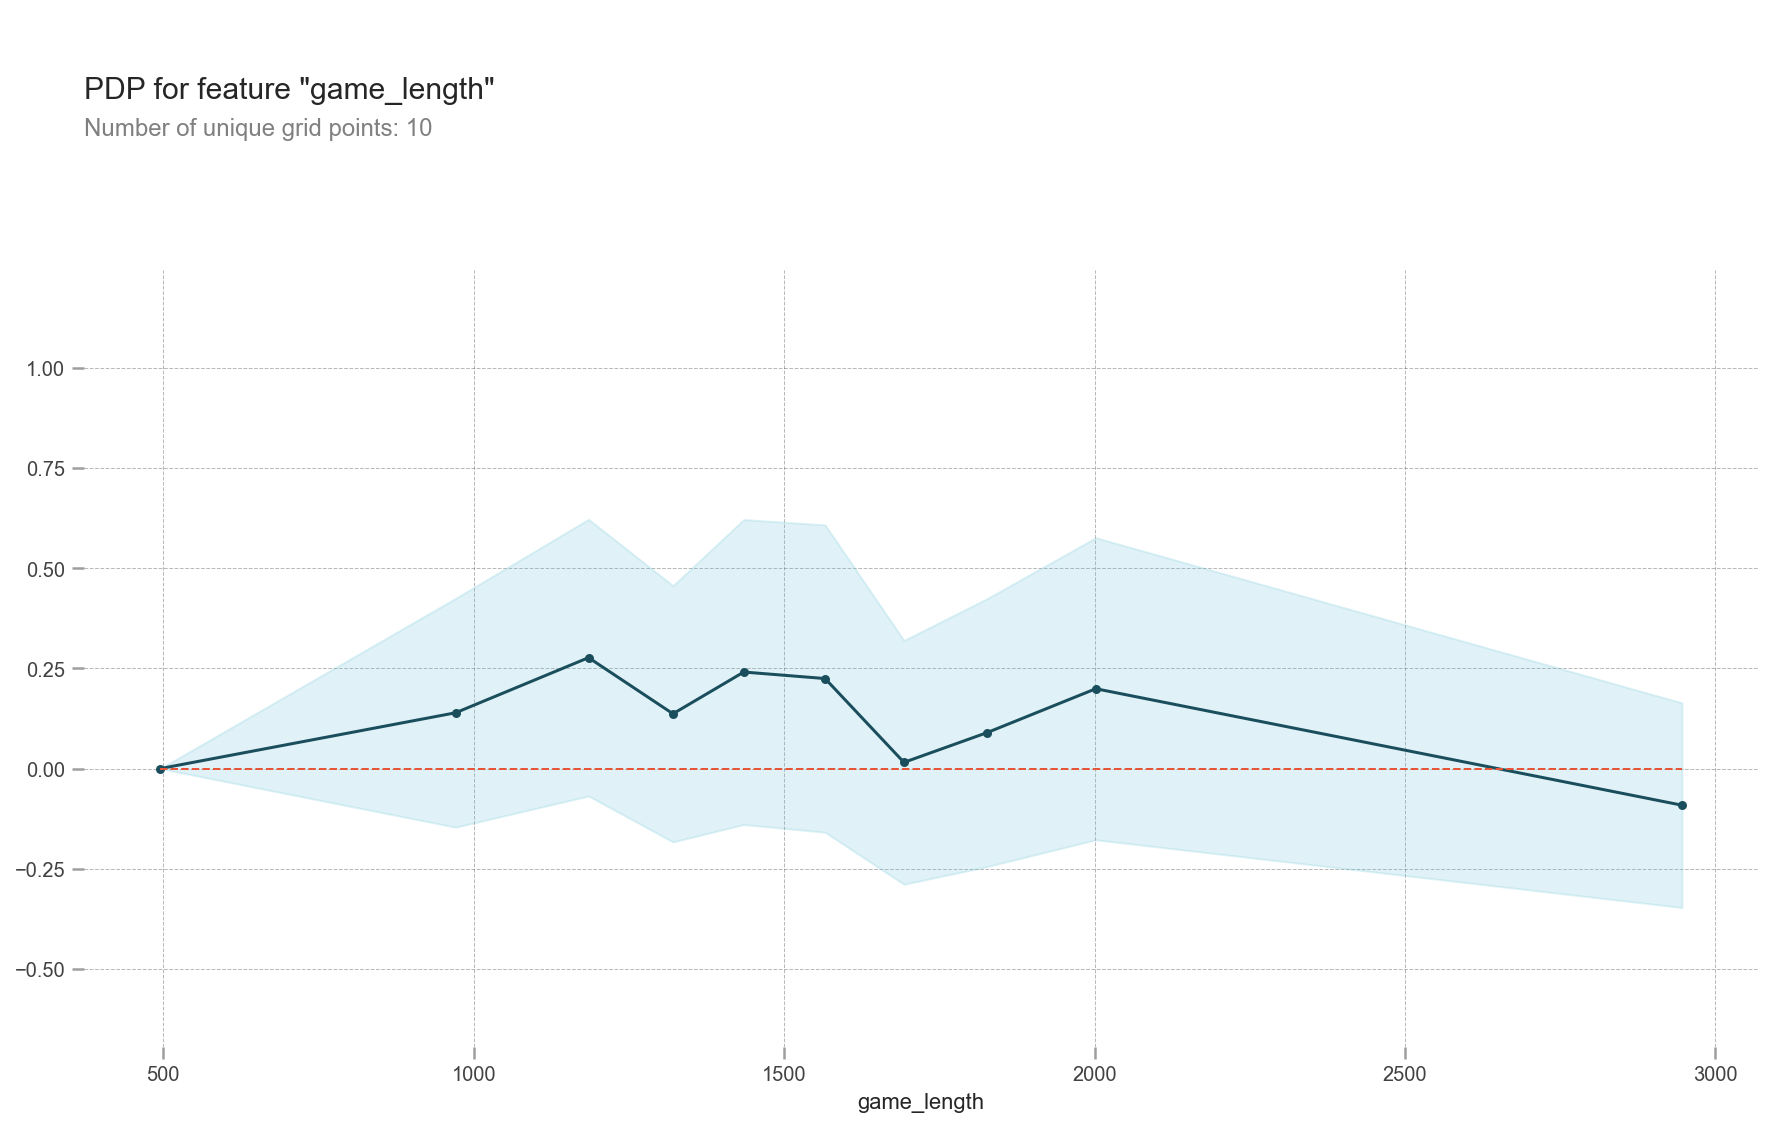

In [249]:
#game_length 특성에 대한 PDP
from pdpbox import pdp
feature = 'game_length'
pdp_dist = pdp.pdp_isolate(model=xgb, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature); 

1. 게임 시간이 승리에 가장 긍정적으로 영향을 미치는 부분은 15분에서 25분 사이이다
2. 게임 시간이 40분을 넘어가면 오히려 레드 팀의 승리에 긍정적이다. (블루는 33분까지만 경기를 끌고가야 한다)

In [261]:
X_encoded_val = encoder.fit_transform(X_val, y_val)
y_pred = xgb.predict(X_encoded_val)

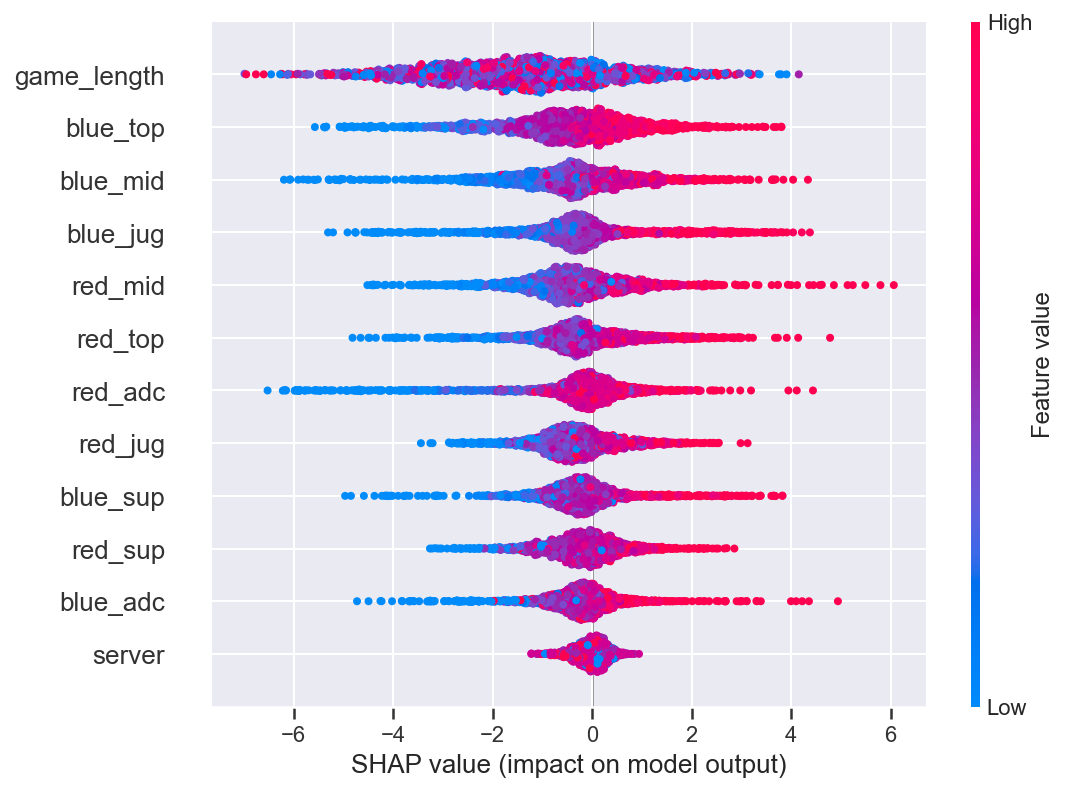

In [262]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_encoded_val)
shap.summary_plot(shap_values, X_encoded_val)

- game_length, 블루 탑, 미드, 정글 순으로 블루 경기 진영 승리에 영향을 끼친다.
- 특이한 것은 블루 진영 서폿보다 블루 진영 원딜이 더 낮은 영향력을 끼친다는 것

In [263]:
row = X_val

In [264]:
feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

In [281]:
pros = shaps.sort_values(ascending=False)[:3].index
cons = shaps.sort_values(ascending=True)[:3].index

In [282]:
print('Victory 예측에 대한 Positive 요인 Top 3 입니다:')
for i, pro in enumerate(pros, start=1):
    feature_name, feature_value = pro
    print(f'{i}. {feature_name} : {feature_value}')

print('\n')
print('Defeat 요인 Top 3 입니다:')
for i, con in enumerate(cons, start=1):
    feature_name, feature_value = con
    print(f'{i}. {feature_name} : {feature_value}')

Victory 예측에 대한 Positive 요인 Top 3 입니다:
1. red_top : Heimerdinger
2. red_sup : Rell
3. blue_adc : Senna


Defeat 요인 Top 3 입니다:
1. blue_jug : Shyvana
2. blue_sup : Leona
3. game_length : 1648


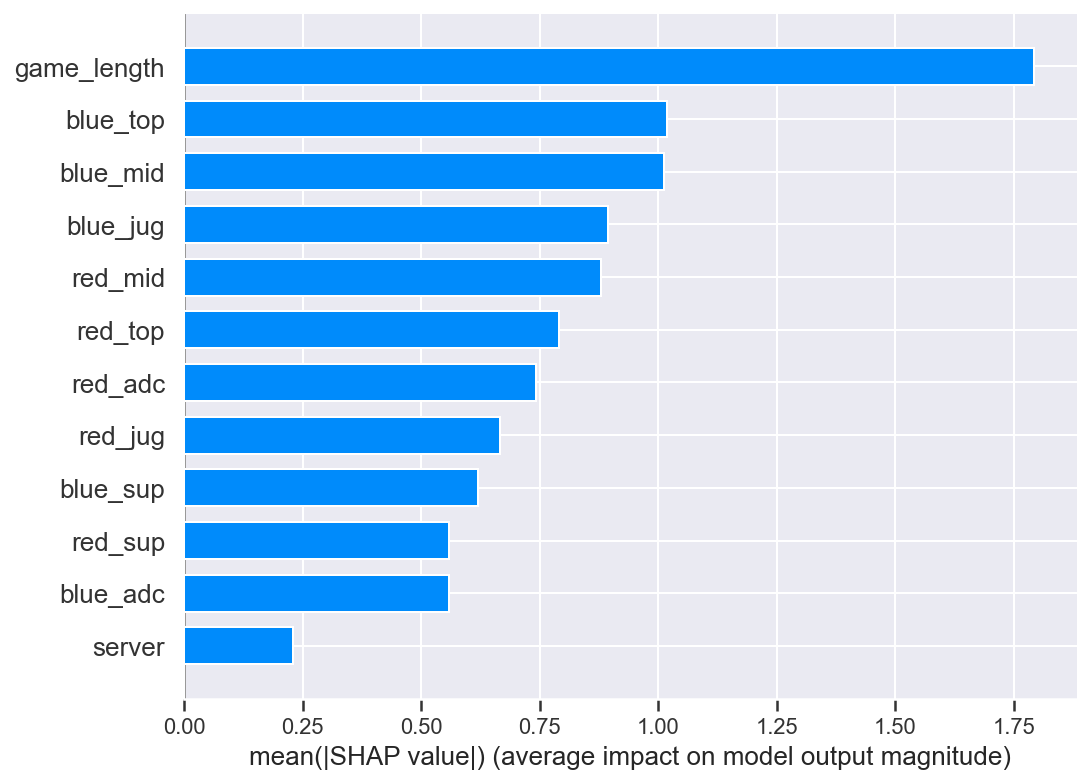

In [270]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

- 게임의 승패에 가장 많은 영향을 끼치는 것은 게임 시간이다
- 포지션 별로 가장 게임 승패에 영향을 끼치는 순위는 블루의 경우 탑, 미드, 정글, 서폿, 원딜이다
- 서버의 경우 박스 플랏을 그려서 알 수 있듯이 크게 영향을 끼치지 않는다.
- 미드 포지션은 전통적으로 다섯 포지션 중 가장 중요하다고 알려져 있는데, 2월달 데이터를 많이 넣지 않은 모델에서는 미드가 가장 낮다고 나왔는데 최근 패치가 있었기 때문인지 다시 미드가 중요한 라인으로 올라섰다. 
- 이렇듯 시즌 단위의 대규모 패치가 아니어도 주기적으로 있는 패치에도 메타가 바뀌는 것을 확인할 수 있다.

#### 보완할 점
- 게임의 승패에 영향을 끼치는 많은 특성들 중 가장 대표적인 라인별 챔프, 게임 시간만 모델에 넣어봤는데, 모델의 f1 score가 그렇게 높지 않았다. 
- 더 높은 예측률을 위해서는, 해당 경기가 트롤링 등을 제외하고 '정상적'으로 진행된 경기의 데이터만 고를 수 있는 특성이 필요하다 (아이템 등)
- 또 챔프 조합만으로는 확실히 경기의 승패를 예측하기 어려워 보인다.
- 게임 외적인 데이터 - 해당 경기가 어떤 패치를 받은 경기인지, 해당 유저가 모스트 챔프를 선택했다면 가중치라던지 등의 데이터 보완이 있으면 더 좋을 듯하다. 